# Walkthrough 7: Atomtronic Terminator
This notebook runs on Oqtant hardware and uses **2 jobs**

## Introduction
Everday electronic devices are composed of circuit elements that serve to control and amplify the flow of electrons.  On the Oqtant hardware, we create and manipulate instead cold neutral atoms, and the field of atomtronics grew out of the need for circuit elements to create and control currents in these systems.   

In atomtronics, a trapped BEC serves the role of a battery, acting as a reservoir with a definite value of chemical (rather than electrical) potential.  The wires in atomtronics correspond to wave guides created by electromagnetic fields along which atoms may travel, and circuit elements can be created by painting light to create bias fields and dynamical landscapes.  

Painted landscapes along one dimension preclude closing a circuit on the Oqtant hardware.  Rather a "terminator" beam can be employed to drain the atoms from one region of the trap, acting analogously to a ground in an electronic circuit.  The name "terminator" comes from radiofrequency circuits where a terminator is employed to eliminate signal reflection and interference.       

In order to generate a terminator for atoms, Oqtant use a laser beam that is resonant with an atomic transition to locally heat atoms until they leave the magnetic trap.  More generally,  the terminator adds a source of dissipation to the Oqtant hardware, allowing users to experiment with an open (rather than isolated) quantum system. 

We direct the interested reader to additional material about atomtronics:
* [Atomtronic battery](https://arxiv.org/abs/1308.1331)
* [Atomtronic transistor](https://iopscience.iop.org/article/10.1088/1367-2630/18/1/015012)
* [Atomtronic roadmap](https://pubs.aip.org/avs/aqs/article/3/3/039201/570637)

## Imports and user authentication ##

In [ ]:
import copy
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from oqtant.schemas.quantum_matter import QuantumMatterFactory
qmf = QuantumMatterFactory()

Binder does not support Oqtant's automatic user authentication methods / widgets, so we authenticate manually:  

1. Copy your access token from [oqtant.infleqtion.com/oqtantAPI](https://oqtant.infleqtion.com/oqtantAPI)
2. Paste that token just below and execute the cell (the if statement keeps the code from executing if you already authenticated above)

In [ ]:
qmf.login.access_token = "Paste your token here between the quotes!"
qmf.get_client()

## Create a single terminator laser pulse

Oqtant QMS supports the addition of a single terminator laser pulse per ```matter``` object. Use ```QuantumMatterFactory``` to create a terminator laser pulse and then add it to a ```QuantumMatter``` object. The terminator beam has fixed position, diameter, intensity, and detuning - more technical details are shown in the Appendix.

In the section below, we establish two experimental setups, each involving 50 nanoKelvin (nK) atoms confined within a double-well potential. Within this potential, a Gaussian-shaped barrier is centered at the cloud's midpoint (0 $\mu m$), featuring an energetic height of 20 kilohertz (kHz), a width of 1 $\mu m$, and a duration of 60 milliseconds (ms).

In the first setup, referred to as the "$\textit{terminator}$" job, we apply the terminator beam onto the atoms from 30 to 33 ms. In contrast, in the second setup, termed the "$\textit{no terminator}$" job, we intentionally refrain from employing the terminator beam for comparison purposes. Currently, only a single terminator pulse is permitted in the experiment, however, more pulses may be incorporated in future upgrades.

In [3]:
terminator = qmf.create_terminator(time_on=30, time_off=33)
barrier = qmf.create_barrier(
    times=[0, 10, 50],
    positions=[0, 0, 0],
    heights=[0, 20, 20],
    widths=[1, 1, 1],
    shape="GAUSSIAN",
)

matter_terminator = qmf.create_quantum_matter(
    temperature=50,
    barriers=[barrier],
    lasers=[terminator],
    lifetime=barrier.death,
    image="IN_TRAP",
    name="terminator",
)

matter_no_terminator = qmf.create_quantum_matter(
    temperature=50,
    barriers=[barrier],
    #     lasers=[terminator],
    lifetime=barrier.death,
    image="IN_TRAP",
    name="no terminator",
)

## Visualize the terminator beam and the combined magnetic/optical potential

What does the terminator beam look like, and where is its position relative to the barrier? If you create a matter object with a terminator beam pulse, you can visualize the position of the beam by including the flag in the ```show_potential([... times ...], include_terminator=True``` function as long as one or more of the specified times falls within the terminator pulse. Here we plot magnetic potential, barrier and terminator on the same plot.

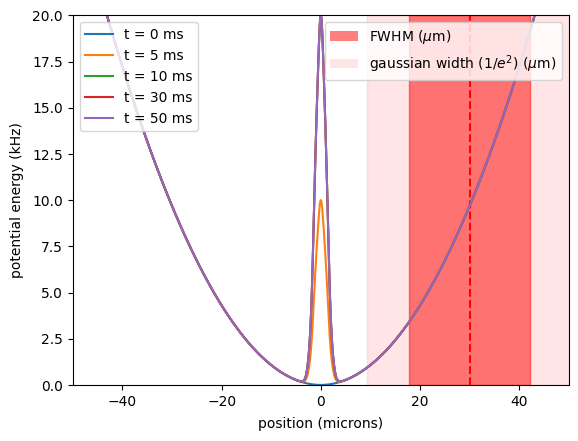

In [4]:
matter_terminator.show_potential(
    [0, 5, 10, 30, 50],
    include_terminator=True,
    include_magnetic=True,
    ylimits=[0, 20],
    xlimits=[-50, 50],
)

## Visualize the timing of the terminator beam pulse

At what point does our terminator pulse initiate and stop during the experiment? Use ```show_laser_pulse_timing()``` to see the timing of the terminator pulse intensity and detuning. Note that the terminator beam is always resonant with the atomic transition, so the detuning will always be zero. 

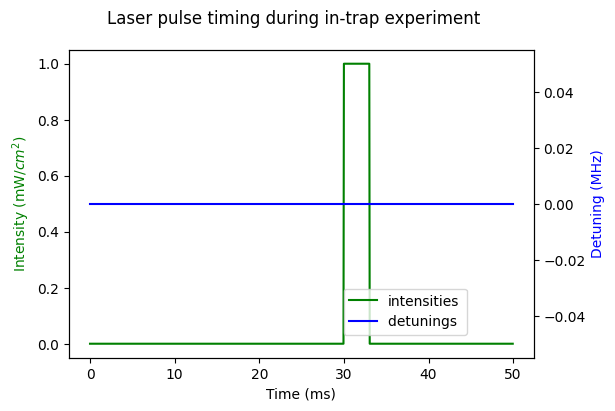

In [5]:
matter_terminator.show_laser_pulse_timing()

## Experiment data with and without terminator:

Let's submit two jobs to compare results with and without the terminator beam. 

In [ ]:
matter_no_terminator.submit(track=True)
matter_terminator.submit(track=True)

Now let's retrieve the results and plot the resulting in-trap images. 

No terminator


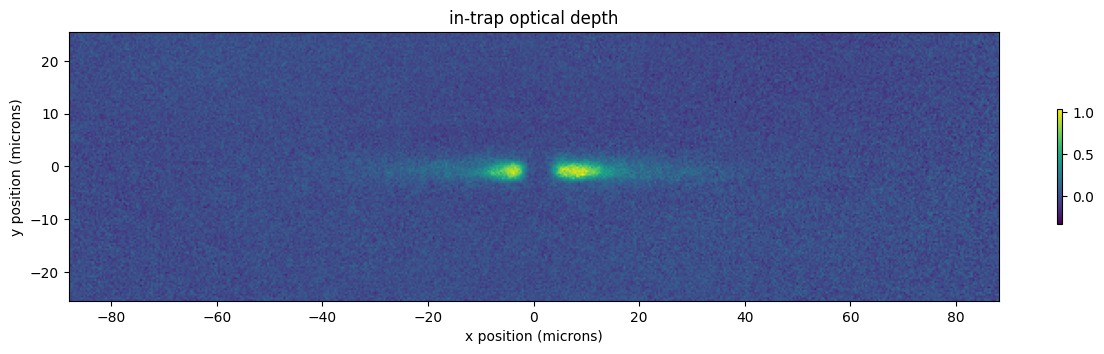

With 3 ms terminator


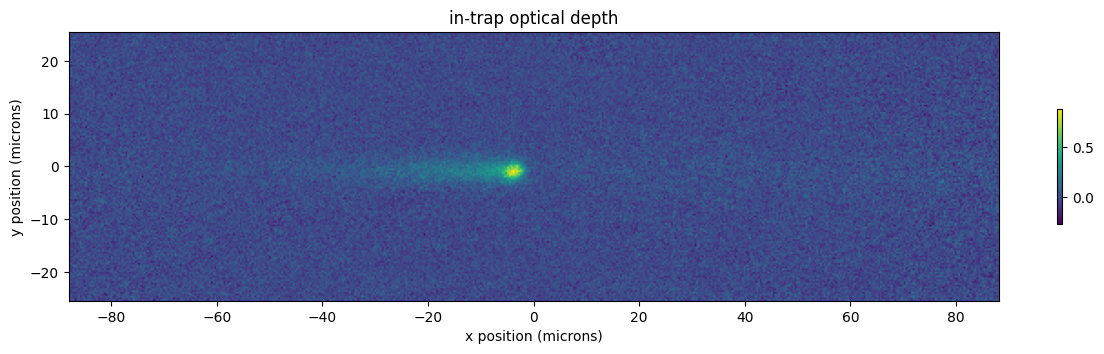

In [8]:
matter_no_terminator.get_result()
matter_terminator.get_result()
print("No terminator")
matter_no_terminator.output.plot_it(figsize=(15, 6))
print("With 3 ms terminator")
matter_terminator.output.plot_it(figsize=(15, 6))

# Conclusion

We observe that a terminator beam lasting 3 ms completely eliminates atoms on the right side of the trap.  Additionally, the barrier in the middle of the trap prevents the atoms on the left side from being eliminated. 


This walkthrough demonstrated how to incorporate terminator features in Oqtant.  Because atoms are outcoupled quickly by the terminator, we encourage users to experiment with the duration of the beam.  Additionally, a short pulse of the terminator is an excellent way to engineer population imbalances on either side of a barrier without longitudinally sweeping barriers or landscapes.    


# Appendix - technical details about the terminator beam

The terminator laser beam is installed in the experiment in a fixed position and power, and the user has access to the duration that the beam is left on. Some more technical details are shown in the table below: 

|Parameter|Value|Note|
|:---|:---|:---|
|Position|30 $\mu m$ | Measured from the center of the magnetic trap to center of gaussian beam| 
|Beam diameter|20 $\mu m$  |$\frac{1}{e^2} $ Diameter|
|Intensity | | Power empirically calibrated to remove atoms from the right half of the field of view in $\textbf{3 ms}$|
|Detuning ( $\Gamma$ ) | 0 MHz| Resonant with the atomic transition
|Pulse shape |SQUARE | Pulse timing and width controlled by AOM |
